In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [69]:
# 1. Load and preprocess data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df.sort_values('date')

# 2. Create sequences
def create_sequence_data(df, sequence_length=30):
    features = ['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'ema_50', 'macd']

    sequence_data = []
    next_day_prices = []
    
    for i in range(len(df) - sequence_length):
        sequence = []
        for feature in features:
            sequence.extend(df[feature].iloc[i:i+sequence_length].values)
        sequence_data.append(sequence)
        next_day_prices.append(df['next_day_close'].iloc[i+sequence_length])
    
    return np.array(sequence_data), np.array(next_day_prices)

from sklearn.decomposition import PCA
# 3. Apply PCA
def apply_pca(X, n_components=60):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    return X_pca, pca

# 4. Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



In [70]:
# Main execution
def main_pca():
    # Load data
    df = load_data('dataset/BTC_Data_2015_2024.csv') 
    df_sub = df.iloc[2036:3407] # Pemilihan data diambil dari pertimbangan harga bitcoin, yaitu sejak harganya menyentuh 10.000 USD
    # Create sequences
    X, y = create_sequence_data(df_sub)
    print("Original sequence shape:", X.shape)
    
    # Scale data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    # Apply PCA
    X_pca, pca_model = apply_pca(X_scaled)
    print("PCA transformed shape:", X_pca.shape)
    
    # Reshape for LSTM [samples, timesteps, features]
    X_reshaped = X_pca.reshape(X_pca.shape[0], 1, X_pca.shape[1])
    
    # Split data
    train_size = int(len(X_reshaped) * 0.8)
    X_train = X_reshaped[:train_size]
    X_test = X_reshaped[train_size:]
    y_train = y_scaled[:train_size]
    y_test = y_scaled[train_size:]
    
    # Build and train model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions)
    actual_values = scaler_y.inverse_transform(y_test)
    
    # Calculate error metrics
    mse = np.mean((predictions - actual_values) ** 2)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")
    
    return model, pca_model, scaler_X, scaler_y, history

if __name__ == "__main__":
    model, pca_model, scaler_X, scaler_y, history = main_pca()

Original sequence shape: (1340, 240)
Explained variance ratio: 0.9984
PCA transformed shape: (1340, 60)
Epoch 1/50


C:\Users\saman\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1615 - val_loss: 0.0462
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 7.0908e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 8.6812e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 4.9232e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 4.8154e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - 

In [71]:
# Main execution
def main():
    # Load data
    df = load_data('dataset/BTC_Data_2015_2024.csv') 
    df_sub = df.iloc[2036:3407] # Pemilihan data diambil dari pertimbangan harga bitcoin, yaitu sejak harganya menyentuh 10.000 USD
    # Create sequences
    X, y = create_sequence_data(df_sub)
    print("Original sequence shape:", X.shape)
    
    # Scale data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    # Without PCA
    
    # Reshape for LSTM [samples, timesteps, features]
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    # Split data
    train_size = int(len(X_reshaped) * 0.8)
    X_train = X_reshaped[:train_size]
    X_test = X_reshaped[train_size:]
    y_train = y_scaled[:train_size]
    y_test = y_scaled[train_size:]
    
    # Build and train model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions)
    actual_values = scaler_y.inverse_transform(y_test)
    
    # Calculate error metrics
    mse = np.mean((predictions - actual_values) ** 2)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")
    return rmse

apalah = main()

Original sequence shape: (1340, 240)
Epoch 1/50


C:\Users\saman\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0689 - val_loss: 0.0025
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 7.1721e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 4.5987e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 5.0628e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 5.2671e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 8.5180e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 5.7766e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 5.7761e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 6.4990e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 5.5786e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 4.1237e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

Original sequence shape: (1340, 240)
Explained variance ratio: 0.9984
PCA transformed shape: (1340, 60)
Epoch 1/50


C:\Users\saman\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1514 - val_loss: 0.0391
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - val_loss: 0.0107
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 7.3812e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 6.0263e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 6.7517e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 4.8565e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 4.2512e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.001

C:\Users\saman\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0710 - val_loss: 0.0046
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 4.5708e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 4.7415e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 6.1434e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 5.9010e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 5.6229e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 5.4720e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 9.0523e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

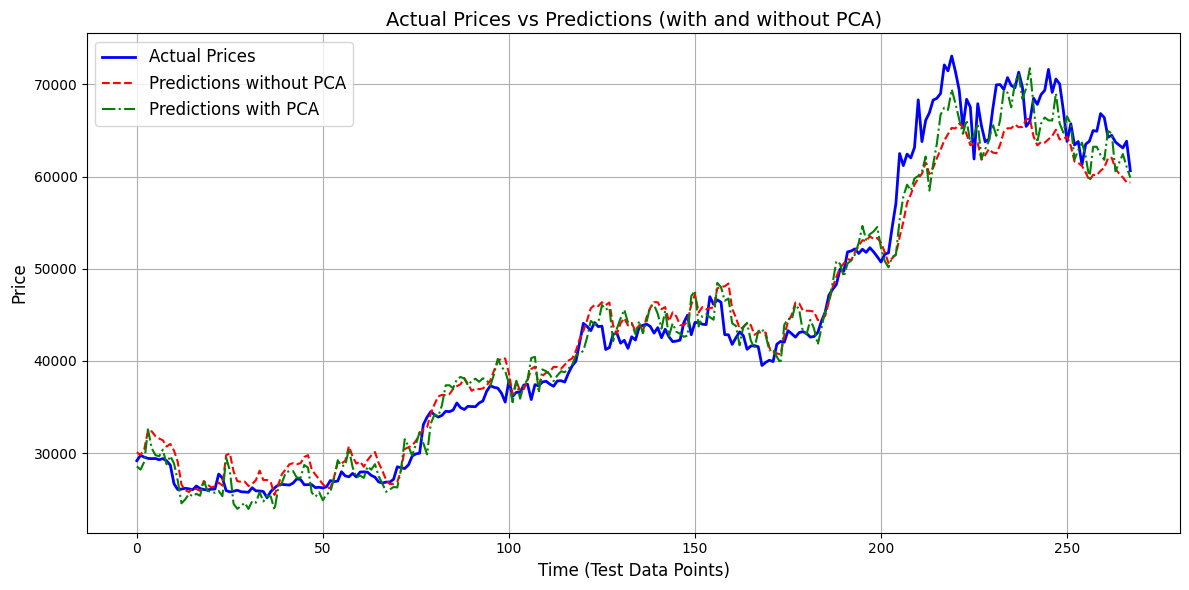

In [73]:
import matplotlib.pyplot as plt

def plot_predictions(actual_values, pred_no_pca, pred_with_pca):
    plt.figure(figsize=(12, 6))
    
    plt.plot(actual_values, label='Actual Prices', color='blue', linewidth=2)
    
    plt.plot(pred_no_pca, label='Predictions without PCA', color='red', linestyle='--', linewidth=1.5)
    
    plt.plot(pred_with_pca, label='Predictions with PCA', color='green', linestyle='-.', linewidth=1.5)
    
    plt.title('Actual Prices vs Predictions (with and without PCA)', fontsize=14)
    plt.xlabel('Time (Test Data Points)', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Train and predict with PCA
model_pca, pca_model, scaler_X, scaler_y, history_pca = main_pca()

# Extract actual values from the scaler
actual_values = scaler_y.inverse_transform(y_test)

# Save predictions with PCA
predictions_with_pca = model_pca.predict(X_test)
predictions_with_pca = scaler_y.inverse_transform(predictions_with_pca)

# Train and predict without PCA (skipping PCA steps)
X_no_pca_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_train_no_pca = X_no_pca_reshaped[:train_size]
X_test_no_pca = X_no_pca_reshaped[train_size:]

model_no_pca = build_model((X_train_no_pca.shape[1], X_train_no_pca.shape[2]))
history_no_pca = model_no_pca.fit(
    X_train_no_pca, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Save predictions without PCA
predictions_no_pca = model_no_pca.predict(X_test_no_pca)
predictions_no_pca = scaler_y.inverse_transform(predictions_no_pca)

# Plot all results
plot_predictions(
    actual_values.flatten(),
    predictions_no_pca.flatten(),
    predictions_with_pca.flatten()
)